In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import mir_eval
import scipy
import librosa

import datasets
import oracles

import matplotlib.pyplot as plt
import matplotlib

In [2]:
def fast_intersect(ref, est):
    """Find all intersections between reference events and estimated events (fast).
    Best-case complexity: O(N log N + M log M) where N=length(ref) and M=length(est)

    Parameters
    ----------
    ref: np.ndarray [shape=(2, n)], real-valued
         Array of reference events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    est: np.ndarray [shape=(2, m)], real-valued
         Array of estimated events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.


    Returns
    -------
    matches: list of sets, length n, integer-valued
         Property: matches[i] contains the set of all indices j such that
            (ref[0, i]<=est[1, j]) AND (ref[1, i]>=est[0, j])
    """
    ref_on_argsort = np.argsort(ref[0, :])
    ref_off_argsort = np.argsort(ref[1, :])

    est_on_argsort = np.argsort(est[0, :])
    est_off_argsort = np.argsort(est[1, :])

    est_on_maxindex = est.shape[1]
    est_off_minindex = 0
    estref_matches = [set()] * ref.shape[1]
    refest_matches = [set()] * ref.shape[1]
    for ref_id in range(ref.shape[1]):
        ref_onset = ref[0, ref_on_argsort[ref_id]]
        est_off_sorted = est[1, est_off_argsort[est_off_minindex:]]
        search_result = np.searchsorted(est_off_sorted, ref_onset, side="left")
        est_off_minindex += search_result
        refest_match = est_off_argsort[est_off_minindex:]
        refest_matches[ref_on_argsort[ref_id]] = set(refest_match)

        ref_offset = ref[1, ref_off_argsort[-1 - ref_id]]
        est_on_sorted = est[0, est_on_argsort[: (1 + est_on_maxindex)]]
        search_result = np.searchsorted(est_on_sorted, ref_offset, side="right")
        est_on_maxindex = search_result - 1
        estref_match = est_on_argsort[: (1 + est_on_maxindex)]
        estref_matches[ref_off_argsort[-1 - ref_id]] = set(estref_match)

    zip_iterator = zip(refest_matches, estref_matches)
    matches = [x.intersection(y) for (x, y) in zip_iterator]
    return matches


def iou(ref, est, method="fast"):
    """Compute pairwise "intersection over union" (IOU) metric between reference
    events and estimated events.

    Let us denote by a_i and b_i the onset and offset of reference event i.
    Let us denote by u_j and v_j the onset and offset of estimated event j.

    The IOU between events i and j is defined as
        (min(b_i, v_j)-max(a_i, u_j)) / (max(b_i, v_j)-min(a_i, u_j))
    if the events are non-disjoint, and equal to zero otherwise.

    Parameters
    ----------
    ref: np.ndarray [shape=(2, n)], real-valued
         Array of reference events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    est: np.ndarray [shape=(2, m)], real-valued
         Array of estimated events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    method: str, optional.
         If "fast" (default), computes pairwise intersections via a custom
         dynamic programming algorithm, see fast_intersect.
         If "slow", computes pairwise intersections via bruteforce quadratic
         search, see slow_intersect.

    Returns
    -------
    S: scipy.sparse.dok.dok_matrix, real-valued
        Sparse 2-D matrix. S[i,j] contains the IOU between ref[i] and est[j]
        if these events are non-disjoint and zero otherwise.
    """
    n_refs = ref.shape[1]
    n_ests = est.shape[1]
    S = scipy.sparse.dok_matrix((n_refs, n_ests))

    if method == "fast":
        matches = fast_intersect(ref, est)
    elif method == "slow":
        matches = slow_intersect(ref, est)

    for ref_id in range(n_refs):
        matching_ests = matches[ref_id]
        ref_on = ref[0, ref_id]
        ref_off = ref[1, ref_id]

        for matching_est_id in matching_ests:
            est_on = est[0, matching_est_id]
            est_off = est[1, matching_est_id]
            intersection = min(ref_off, est_off) - max(ref_on, est_on)
            union = max(ref_off, est_off) - min(ref_on, est_on)
            intersection_over_union = intersection / union
            S[ref_id, matching_est_id] = intersection_over_union

    return S


def match_events(ref, est, min_iou=0.0, method="fast"):
    """
    Compute a maximum matching between reference and estimated event times,
    subject to a criterion of minimum intersection-over-union (IOU).

    Given two lists of events ``ref`` (reference) and ``est`` (estimated),
    we seek the largest set of correspondences ``(ref[i], est[j])`` such that
        ``iou(ref[i], est[j]) <= min_iou``
    and such that each ``ref[i]`` and ``est[j]`` is matched at most once.

    This function is strongly inspired by mir_eval.onset.util.match_events.
    It relies on mir_eval's implementation of the Hopcroft-Karp algorithm from
    maximum bipartite graph matching. However, one important difference is that
    mir_eval's distance function relies purely on onset times, whereas this function
    considers both onset times and offset times to compute the IOU metric between
    reference events and estimated events.

    Parameters
    ----------
    ref: np.ndarray [shape=(2, n)], real-valued
         Array of reference events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    est: np.ndarray [shape=(2, m)], real-valued
         Array of estimated events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    min_iou: real number in [0, 1). Default: 0.
         Threshold for minimum amount of intersection over union (IOU) to match
         any two events. See the iou method for implementation details.

    method: str, optional.
         If "fast" (default), computes pairwise intersections via a custom
         dynamic programming algorithm, see fast_intersect.
         If "slow", computes pairwise intersections via bruteforce quadratic
         search, see slow_intersect.

    Returns
    -------
    matching : list of tuples
        Every tuple corresponds to a match between one reference event and
        one estimated event.
            ``matching[i] == (i, j)`` where ``ref[i]`` matches ``est[j]``.
        Note that all values i and j appear at most once in the list.
    """

    # Intersect reference events and estimated events
    S = iou(ref, est, method=method)

    # Threshold intersection-over-union (IOU) ratio
    S_bool = scipy.sparse.dok_matrix(S > min_iou)
    hits = S_bool.keys()

    # Construct the bipartite graph
    G = {}
    for ref_i, est_i in hits:
        if est_i not in G:
            G[est_i] = []
        G[est_i].append(ref_i)

    # Apply Hopcroft-Karp algorithm (from mir_eval package)
    # to obtain maximum bipartite graph matching
    matching = sorted(mir_eval.util._bipartite_match(G).items())
    return matching


def slow_intersect(ref, est):
    """Find all intersections between reference events and estimated events (slow).
    Best-case complexity: O(N*M) where N=ref.shape[1] and M=est.shape[1]

    Parameters
    ----------
    ref: np.ndarray [shape=(2, n)], real-valued
         Array of reference events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    est: np.ndarray [shape=(2, m)], real-valued
         Array of estimated events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.


    Returns
    -------
    matches: list of sets, length n, integer-valued
         Property: matches[i] contains the set of all indices j such that
            (ref[0, i]<=est[1, j]) AND (ref[1, i]>=est[0, j])
    """
    matches = []
    for i in range(ref.shape[1]):
        matches.append(
            set(
                [
                    j
                    for j in range(est.shape[1])
                    if ((ref[0, i] <= est[1, j]) and (ref[1, i] >= est[0, j]))
                ]
            )
        )
    return matches

In [3]:
def compute_tp_fp_fn(events_ref, events_pred, min_iou=0.3):

    if len(events_pred) == 0:
        return 0, 0, len(events_ref), len(events_ref)
    
    events_ref_ndarray = np.array(events_ref).transpose() # shape (n, 2) -> (2, n)
    events_pred_ndarray = np.array(events_pred).transpose() # shape (m, 2) -> (2, m)

    matches = match_events(events_ref_ndarray, events_pred_ndarray, min_iou=min_iou)
    tp = len(matches)
    fp = len(events_pred) - tp
    fn = len(events_ref) - tp
    total_events = len(events_ref)

    return tp, fp, fn, total_events

def precision_score(tp, fp):
    return tp / (tp + fp)

def recall_score(tp, fn):
    return tp / (tp + fn)

def f1_score(precision, recall):
    return (2 * precision * recall) / (precision + recall)

def f1_score_from_events(events_ref, events_pred, min_iou):
    tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred, min_iou)

    # TODO: what should this be?
    if tp + fp == 0:
        return 0
    
    precision = precision_score(tp, fp)
    recall    = recall_score(tp, fn)

    # TODO: what should this be?
    if precision + recall == 0:
        return 0
    
    f1 = f1_score(precision, recall)
    return f1

print("Test 1.")
print("----------------------------------------")
events_ref  = [(0,1), (2,3), (4,5)]
events_pred = [(0,1),        (4,5)]
print("expected : tp = 2, fp = 0, fn = 1")
tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred)
print("output   : tp = {}, fp = {}, fn = {}".format(tp, fp, fn))

precision = precision_score(tp, fp)
recall = recall_score(tp, fn)
f1 = f1_score(precision, recall)
#print("expected precision: 1.0")
#print("output   precision: {}".format(precision))
#print("expected recall: 0.67")
#print("output   precision: {:.2f}".format(recall))
#print("expected f1 score: 0.80")
#print("output   f1 score: {:.2f}".format(f1))
print("----------------------------------------")

print("Test 2.")
print("----------------------------------------")
events_ref  = [(0,1), (2,3), (4,5)]
events_pred = [(0,1), (1,2), (4,5)]
print("expected : tp = 2, fp = 1, fn = 1")
tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred)
print("output   : tp = {}, fp = {}, fn = {}".format(tp, fp, fn))
print("----------------------------------------")

print("Test 3.")
print("----------------------------------------")
events_ref  = [(0,1),   (2,3),            (4,5)]
events_pred = [(0,0.5), (2,2.5),(2.5, 3), (4,4.5)]
print("expected : tp = 3, fp = 1, fn = 0")
tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred, min_iou=0.3)
print("output   : tp = {}, fp = {}, fn = {}".format(tp, fp, fn))
print("----------------------------------------")

print("Test 4.")
print("----------------------------------------")
events_ref  = [(0,1),   (2,3),   (4,5)]
events_pred = [(0,0.6), (2,2.5), (4,4.5)]
print("expected : tp = 1, fp = 2, fn = 2")
tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred, min_iou=0.5)
print("output   : tp = {}, fp = {}, fn = {}".format(tp, fp, fn))
print("----------------------------------------")

Test 1.
----------------------------------------
expected : tp = 2, fp = 0, fn = 1
output   : tp = 2, fp = 0, fn = 1
----------------------------------------
Test 2.
----------------------------------------
expected : tp = 2, fp = 1, fn = 1
output   : tp = 2, fp = 1, fn = 1
----------------------------------------
Test 3.
----------------------------------------
expected : tp = 3, fp = 1, fn = 0
output   : tp = 3, fp = 1, fn = 0
----------------------------------------
Test 4.
----------------------------------------
expected : tp = 1, fp = 2, fn = 2
output   : tp = 1, fp = 2, fn = 2
----------------------------------------


In [203]:
def load_annotations(ref_path):
    annotations = []
    
    with open(ref_path, 'r') as f:
        ls = f.readlines()
        for l in ls:
            ds = l.split('\t')
            start_time = float(ds[0])
            end_time = float(ds[1])
            #class_name = ds[2]
            #annotations.append((start_time, end_time, class_name))
            annotations.append((start_time, end_time))
    return annotations
    
def compute_neg_ref(pos_ref, soundscape_length):
    neg_ref = []
    prev_pos_end_time   = 0
    for (curr_pos_start_time, curr_pos_end_time) in pos_ref:
        neg_start_time = prev_pos_end_time
        neg_end_time   = curr_pos_start_time
        neg_ref.append((neg_start_time, neg_end_time))
    
        prev_pos_end_time   = curr_pos_end_time
    
    if prev_pos_end_time < soundscape_length:
        neg_ref.append((prev_pos_end_time, soundscape_length))
    return neg_ref

In [204]:
def annotator_cost(start_time, end_time, cost_linear, cost_overhead):
    segment_cost = (end_time - start_time) * cost_linear + cost_overhead
    return segment_cost

def cost_of_queries(queries, cost_linear, cost_overhead):
    cost = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in queries])
    return cost

def pos_events_from_queries(queries, oracle, soundscape_basename):
    pos_events = []
    for (q_st, q_et) in queries:
        c = oracle.query(q_st, q_et, soundscape_basename)
        if c == 1:
            pos_events.append((q_st, q_et))
    return pos_events

base_dir = '../soundscapes/ME/test'
soundscape_basename = 'ME1'

ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
me1_pos_ref = load_annotations(ref_path)
me1_neg_ref = compute_neg_ref(me1_pos_ref, 30)

oracle = oracles.WeakLabelOracle(base_dir = base_dir)
min_iou = 0.0

annotations = me1_pos_ref + me1_neg_ref
annotations = sorted(annotations, key=lambda x: x[0])
#annotations = [(0, annotations[0][0])] + annotations
adp_queries = []

min_query_length = 1
max_query_length = 60

idx_ann = 0
end_time = annotations[-1][1]
create_query = True
while create_query:
    (ann_start_time, ann_end_time) = annotations[idx_ann]
    l = ann_end_time - ann_start_time
    
    if l < min_query_length:
        query_start_time = ann_start_time
        query_end_time = query_start_time + min_query_length
        q = (query_start_time, query_end_time)

        if query_end_time > end_time:
            pop = False
            create_query = False
        else:
            pop = True
        adp_queries.append(q)

        while pop:
            ann_end_time = annotations[idx_ann][1]
            if ann_end_time < query_end_time:
                idx_ann += 1
            else:
                pop = False
    else:
        q = (ann_start_time, ann_end_time)
        adp_queries.append(q)
    idx_ann += 1
    if idx_ann >= len(annotations):
        create_query = False
        
# adjust queries    
add_queries = []
for idx_q in range(len(adp_queries)-1):
    q1 = adp_queries[idx_q]
    q2 = adp_queries[idx_q + 1]

    l = q2[0] - q1[1]
    if l < min_query_length:
        adp_queries[idx_q] = (q1[0], q2[0])
    else:
        q = (q1[1], q2[0])
        add_queries.append(q)

adp_queries = adp_queries + add_queries
adp_queries = sorted(adp_queries, key = lambda x: x[0])

cost_overhead = 10
cost_linear = 1

me1_pos_pred = pos_events_from_queries(adp_queries, oracle, soundscape_basename)
print("f1 score (adaptive) : ", f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou))
print("cost     (adaptive) : ", cost_of_queries(adp_queries, cost_linear=cost_linear, cost_overhead=cost_overhead))

fix_queries = np.linspace(0, 536, int(536/min_query_length))
fix_queries = list(zip(fix_queries[:-1], fix_queries[1:]))
me1_pos_pred = pos_events_from_queries(fix_queries, oracle, soundscape_basename)
print("f1 score (fixed)    : ", f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou))
print("cost     (fixed)    : ", cost_of_queries(fix_queries, cost_linear=cost_linear, cost_overhead=cost_overhead))

f1 score (adaptive) :  0.8571428571428571
cost     (adaptive) :  756.097
f1 score (fixed)    :  0.8148148148148148
cost     (fixed)    :  5886.0


# Change-point detection

In [205]:
from scipy.signal import find_peaks

peaks:  [7, 10, 2, 5]
promnences:  [1.0, 1.0, 0.85, 0.85]


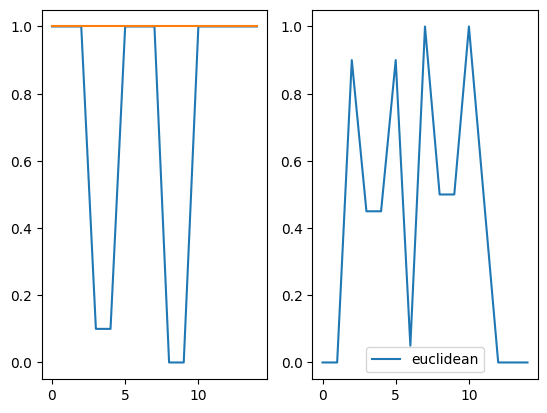

In [221]:
def shift_bit_length(x):
    x = int(x)
    return 1<<(x-1).bit_length()

def next_power_of_2(x):
    return shift_bit_length(x)

def change_point_detection_wav(wav, sample_rate, threshold=0.5):
    """
        Detects the timing of the change-points for the waveform given the supplied threshold.

        Input:
            wav         : the waveform
            sample_rate : the sample rate of the waveform
            threshold   : the threshold for the change-point detection

        Output: 
            [t_1, t_2, ..., t_m] : the m change-points
    """

    window_length = 0.025
    n_fft = next_power_of_2(int(sample_rate * window_length))
    
    mel_spectrogram = librosa.feature.melspectrogram(
        y     = wav,
        sr    = sample_rate,
        n_fft = n_fft,
        hop_length = n_fft // 2,
        n_mels = 128,
    )

def cosine_distance_score(x1, x2):
    return 1 - np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

def euclidean_distance_score(x1, x2):
    return np.sqrt(np.sum(np.power(x1 - x2, 2)))

def cosine_distance_past_and_future_averages(embeddings, offset=5, M=5):
    ds = distance_past_and_future_averages(embeddings, cosine_distance_score, offset, M)
    return ds

def distance_past_and_future_averages(embeddings, distance_fn, offset=5, M=5):
    ds = np.zeros(len(embeddings))

    for idx in range(M+offset, len(embeddings)-M-offset):
        past_start = idx-M-offset
        past_end   = idx-offset
        future_start = idx+1+offset
        future_end = idx+M+1+offset

        #print("past    : ", past_start, past_end)
        #print("current : ", idx)
        #print("future  : ", future_start, future_end)

        past_mean   = np.mean(embeddings[past_start:past_end,:], axis=0)
        future_mean = np.mean(embeddings[future_start:future_end,:], axis=0)

        cosine_distance = distance_fn(past_mean, future_mean)

        ds[idx] = cosine_distance

    return ds

def change_point_detection_from_embeddings(embeddings, timings, M = 3, prominence=0, n_peaks=5):
    """
        Detects the timing of the change-points for the waveform given the supplied threshold.

        Input:
            embeddings : shape (n, 1024), the BirdNET-Analyser embeddings
            timings    : shape (n, 2)   , the onset and offset of the embeddings

        Output: 
            [t_1, t_2, ..., t_m] : the m change-points
    """

    emb_hop_length = timings[1][0] - timings[0][0]
    emb_win_length = timings[0][1] - timings[0][0]

    offset = int((emb_win_length-emb_hop_length) / emb_hop_length)

    ds = distance_past_and_future_averages(embeddings, distance_fn=cosine_distance_score, offset=offset, M = M)

    peaks = find_peaks(ds, prominence=prominence)

    # sort peaks by prominence
    peak_indices = peaks[0]
    peak_prominences = peaks[1]['prominences']
    xs = sorted(list(zip(peak_indices, peak_prominences)), key=lambda x: x[1], reverse=True)

    # sort by indice
    peak_indices_sorted = sorted([x[0] for x in xs[:n_peaks]])
    #peak_prominences_sorted = [x[1] for x in xs]

    # return most prominent peaks
    peak_timings = np.mean(timings[peak_indices_sorted], axis=1)
    
    return list(peak_timings), ds

# sanity check
distance_metric = 'euclidean'

if distance_metric == 'cosine':
    distance_fn = cosine_distance_score
elif distance_metric == 'euclidean':
    distance_fn = euclidean_distance_score

embeddings = np.ones((15, 2))
embeddings[3:5, 0] = 0.1
embeddings[8:10, 0] = 0
fig, ax = plt.subplots(1,2)
ax[0].plot(embeddings[:,0], label='dim 0')
ax[0].plot(embeddings[:,1], label='dim 1')
ds = distance_past_and_future_averages(embeddings, distance_fn=distance_fn, offset=0, M=2)
ax[1].plot(ds, label=distance_metric)
plt.legend()
peaks = find_peaks(ds, prominence=0.5) # Understand prominence ....
peak_indices = peaks[0]
peak_prominences = peaks[1]['prominences']

# sort by prominence
xs = sorted(list(zip(peak_indices, peak_prominences)), key=lambda x: x[1], reverse=True)
peak_indices_sorted = [x[0] for x in xs]
peak_prominences_sorted = [x[1] for x in xs]

print("peaks: ", peak_indices_sorted)
print("promnences: ", peak_prominences_sorted)

timings:  (59, 2)
embeddings:  (59, 1024)
[6.5, 8.5, 10.0, 11.5, 13.5, 23.0, 26.5]


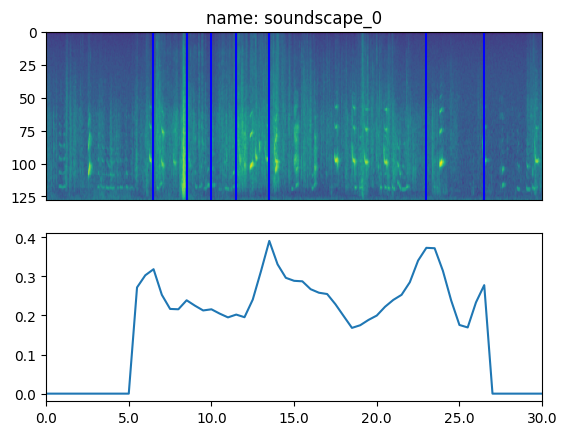

In [222]:
base_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_soundscapes_snr_10.0/'
soundscape_basename = 'soundscape_0'
embedding_path = os.path.join(base_dir, '{}.birdnet.embeddings.txt'.format(soundscape_basename))

timings_and_embeddings = datasets.load_timings_and_embeddings(
    file_path=embedding_path,
    embedding_dim=1024
)

timings    = np.array([[s, e] for (s, e, _) in timings_and_embeddings])
embeddings = np.array([r for (_, _, r) in timings_and_embeddings])
print("timings: ", timings.shape)
print("embeddings: ", embeddings.shape)

#threshold = 7.5 #0.25
#prominence = 0.8
M = 3
peaks, ds = change_point_detection_from_embeddings(
    embeddings,
    timings,
    M = M,
    prominence = 0,
    n_peaks = 10,
)
# M = 3
# ds = cosine_distance_past_and_future_averages(embeddings, M=M)
#plt.plot(ds)

emb_window_length = 3.0
emb_hop_length = 0.5

# align in time
time_align = int(np.ceil((emb_window_length / 2) / emb_hop_length))
time_aligned_ds = np.concatenate((np.zeros(time_align), ds[:-1]))

# extract Mel spectrogram
wave, sr = librosa.load(os.path.join(base_dir, soundscape_basename + ".wav"))
window_length = 0.025
n_fft = next_power_of_2(int(sr * window_length))
mel_spectrogram = librosa.feature.melspectrogram(
    y=wave,
    sr=sr,
    n_fft = n_fft,
    hop_length = n_fft // 2,
)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(np.flip(np.log(mel_spectrogram + 1e-10), axis=0), aspect='auto')
ax[0].set_title("name: {}".format(soundscape_basename))
ax[0].set_xticks([])
ax[1].plot(time_aligned_ds, label='prediction')
ax[1].set_xlim(0, len(time_aligned_ds)-1)
#ax[1].set_ylim(0, 1.1)
#ax[1].axhline(threshold, color='red')

xticks = ax[1].get_xticks()
xtickslabels = np.linspace(0, 30, len(xticks))
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xtickslabels)

N = mel_spectrogram.shape[1]
dt = 30 / N

print(peaks)
peak_frame_indices = [int(c / dt) for c in peaks]
#average_change_point_frame_indices = [int(c / dt) for c in averages_change_points]

#for change_point_frame_idx in change_point_frame_indices:
#    ax[0].axvline(change_point_frame_idx, color='red')
for peak_frame_idx in peak_frame_indices:
    ax[0].axvline(peak_frame_idx, color='blue')



In [225]:
snr = '10.0'
cost_linear = 1.0
cost_overhead = 10.0
min_iou = 0.01

# SETTINGS: change-point detection query strategy
prominence = 0
M = 1

# SETTING: fixed query strategy
n_fix_queries = 7

fix_costs = []
cp_costs = []
opt_costs = []

fix_label_qualities = []
cp_label_qualities = []
opt_label_qualities = []

cp_lengths = []

# TODO: set a budget

for idx_soundscape in range(50):
    base_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_soundscapes_snr_{}/'.format(snr)
    soundscape_basename = 'soundscape_{}'.format(idx_soundscape)
    wave, sr = librosa.load(os.path.join(base_dir, soundscape_basename + ".wav"))

    # create oracle
    oracle = oracles.WeakLabelOracle(base_dir)
    
    embedding_path = os.path.join(base_dir, '{}.birdnet.embeddings.txt'.format(soundscape_basename))
    
    timings_and_embeddings = datasets.load_timings_and_embeddings(
        file_path=embedding_path,
        embedding_dim=1024
    )
    
    timings    = np.array([[s, e] for (s, e, _) in timings_and_embeddings])
    embeddings = np.array([r for (_, _, r) in timings_and_embeddings])

    # extract change-points
    peak_timings, ds = change_point_detection_from_embeddings(
        embeddings,
        timings,
        M = M,
        prominence = 0,
        n_peaks = n_fix_queries-1
    )

    # create change-point queries
    query_starts  = [0] + peak_timings
    query_ends = peak_timings + [soundscape_length]
    cp_queries = list(zip(query_starts, query_ends))

    # create fix queries
    soundscape_length = len(wave) / sr
    fix_queries = np.linspace(0, soundscape_length, n_fix_queries+1)
    fix_queries = list(zip(fix_queries[:-1], fix_queries[1:]))

    # create opt queries
    ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
    pos_ref  = load_annotations(ref_path)
    neg_ref  = compute_neg_ref(pos_ref, soundscape_length=soundscape_length)
    opt_queries = pos_ref + neg_ref

    # rank the queries and choose until the budget for this soundscape is spent

    # compute costs of queries
    fix_cost = cost_of_queries(fix_queries, cost_linear, cost_overhead)
    cp_cost  = cost_of_queries(cp_queries,  cost_linear, cost_overhead)
    opt_cost = cost_of_queries(opt_queries, cost_linear, cost_overhead)

    cp_lengths.append([e-s for (s, e) in cp_queries])

    opt_costs.append(opt_cost)
    fix_costs.append(fix_cost)
    cp_costs.append(cp_cost)

    # compute label-quality of queries
    fix_pos_pred = pos_events_from_queries(fix_queries, oracle, soundscape_basename)
    cp_pos_pred  = pos_events_from_queries(cp_queries,  oracle, soundscape_basename)
    opt_pos_pred = pos_events_from_queries(opt_queries, oracle, soundscape_basename)
    
    fix_f1 = f1_score_from_events(pos_ref, fix_pos_pred, min_iou=min_iou)
    cp_f1  = f1_score_from_events(pos_ref, cp_pos_pred,  min_iou=min_iou)
    opt_f1 = f1_score_from_events(pos_ref, opt_pos_pred, min_iou=min_iou)

    cp_label_qualities.append(cp_f1)
    fix_label_qualities.append(fix_f1)
    opt_label_qualities.append(opt_f1)

print("optimal queries,      cost = {:.2f}, label-quality = {:.3f}".format(np.mean(opt_costs), np.mean(opt_label_qualities)))
fix_std = np.std(fix_label_qualities)
fix_mean = np.mean(fix_label_qualities)
cp_std = np.std(cp_label_qualities)
cp_mean = np.mean(cp_label_qualities)

print("fixed queries,        cost = {:.2f}, label-quality = {:.3f} +- {:.3f}".format(np.mean(fix_costs), fix_mean, fix_std))
print("change-point queries, cost = {:.2f}, label-quality = {:.3f} +- {:.3f}".format(np.mean(cp_costs), cp_mean, cp_std))

optimal queries,      cost = 100.00, label-quality = 1.000
fixed queries,        cost = 100.00, label-quality = 0.890 +- 0.137
change-point queries, cost = 100.00, label-quality = 0.916 +- 0.125


In [111]:
ls = np.concatenate(cp_lengths)
print("mean: ", np.mean(ls))
print("median: ", np.median(ls))
print("min: ", np.min(ls))
print("max: ", np.max(ls))
#print(np.sum(ls < 2))

mean:  7.009345794392523
median:  6.0
min:  2.0
max:  23.0


# TODO: reasonable overhead costs?

In [57]:
queries

[(0, 6.533),
 (6.533, 10.004),
 (10.004, 13.045),
 (13.045, 17.963),
 (17.963, 20.963),
 (20.963, 28.83),
 (28.83, 32.316),
 (32.316, 35.316),
 (35.316, 462.66),
 (462.66, 465.66),
 (465.66, 472.77),
 (472.77, 475.77),
 (475.77, 535.097),
 (535.097, 538.097)]

In [58]:
fix_queries

[(0.0, 1.0018691588785047),
 (1.0018691588785047, 2.0037383177570094),
 (2.0037383177570094, 3.005607476635514),
 (3.005607476635514, 4.007476635514019),
 (4.007476635514019, 5.009345794392523),
 (5.009345794392523, 6.011214953271028),
 (6.011214953271028, 7.013084112149533),
 (7.013084112149533, 8.014953271028038),
 (8.014953271028038, 9.016822429906542),
 (9.016822429906542, 10.018691588785046),
 (10.018691588785046, 11.020560747663552),
 (11.020560747663552, 12.022429906542056),
 (12.022429906542056, 13.02429906542056),
 (13.02429906542056, 14.026168224299067),
 (14.026168224299067, 15.02803738317757),
 (15.02803738317757, 16.029906542056075),
 (16.029906542056075, 17.03177570093458),
 (17.03177570093458, 18.033644859813084),
 (18.033644859813084, 19.03551401869159),
 (19.03551401869159, 20.037383177570092),
 (20.037383177570092, 21.039252336448598),
 (21.039252336448598, 22.041121495327104),
 (22.041121495327104, 23.042990654205607),
 (23.042990654205607, 24.044859813084113),
 (24.

In [46]:


base_dir = '../soundscapes/ME/test'
soundscape_basename = 'ME1'

ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
me1_pos_ref = load_annotations(ref_path)
me1_neg_ref = compute_neg_ref(me1_pos_ref)

oracle = oracles.WeakLabelOracle(base_dir = base_dir)


file_end_time = me1_pos_ref[-1][1]

n_segment_lengths = 50
min_segment_length = 1
max_segment_length = 30
segment_lengths = np.linspace(min_segment_length, max_segment_length, n_segment_lengths)

n_cost_overheads = 50
min_cost_overhead = 0
max_cost_overhead = 20
cost_overheads = np.linspace(min_cost_overhead, max_cost_overhead, n_cost_overheads)

# label_quality_ratio_result = np.zeros((n_segment_lengths, n_cost_overheads))
# cost_ratio_result = np.zeros((n_segment_lengths, n_cost_overheads))

label_quality_fixed = np.zeros((n_segment_lengths, n_cost_overheads))
cost_fixed = np.zeros((n_segment_lengths, n_cost_overheads))

label_quality_oracle = np.zeros((n_segment_lengths, n_cost_overheads))
cost_oracle = np.zeros((n_segment_lengths, n_cost_overheads))


cost_linear = 1
min_iou = 0.01 #0.025 * 3

#segment_lengths = [1.0]
#cost_overheads = [100.0]

for idx_seg, segment_length in enumerate(segment_lengths):
    for idx_cost, cost_overhead in enumerate(cost_overheads):

        # ORACLE: compute cost of optimal query strategy (recovers true labels using weak-labels)
        cost_opt_query_pos = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in me1_pos_ref])
        cost_opt_query_neg = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in me1_neg_ref])
        cost_opt_query = cost_opt_query_neg + cost_opt_query_pos
        f1_opt = f1_score_from_events(me1_pos_ref, me1_pos_ref, min_iou=min_iou)

        # FIXED: compute cost of segment query strategy
        time_counter = 0.0
        cost_fix_query = 0.0
        me1_pos_pred = []
        
        # simulate annotation of the whole file
        while time_counter < file_end_time:
            query_start_time = time_counter
            query_end_time   = time_counter + (segment_length)
    
            # get annotation
            c = oracle.query(query_start_time, query_end_time, soundscape_basename)
            if c == 1:
                me1_pos_pred.append((query_start_time, query_end_time))
    
            # get cost
            cost = annotator_cost(query_start_time, query_end_time, cost_linear, cost_overhead)
            cost_fix_query += cost
    
            # increase time counter
            time_counter += segment_length

        f1 = f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou)

        # baseline
        label_quality_fixed[idx_seg, idx_cost] = f1
        cost_fixed[idx_seg, idx_cost] = cost_fix_query

        # oracle
        label_quality_oracle[idx_seg, idx_cost] = f1_opt
        cost_oracle[idx_seg, idx_cost] = cost_opt_query

        # bounded-oracle

(50, 50)
(50, 50)
0.43915399422756474


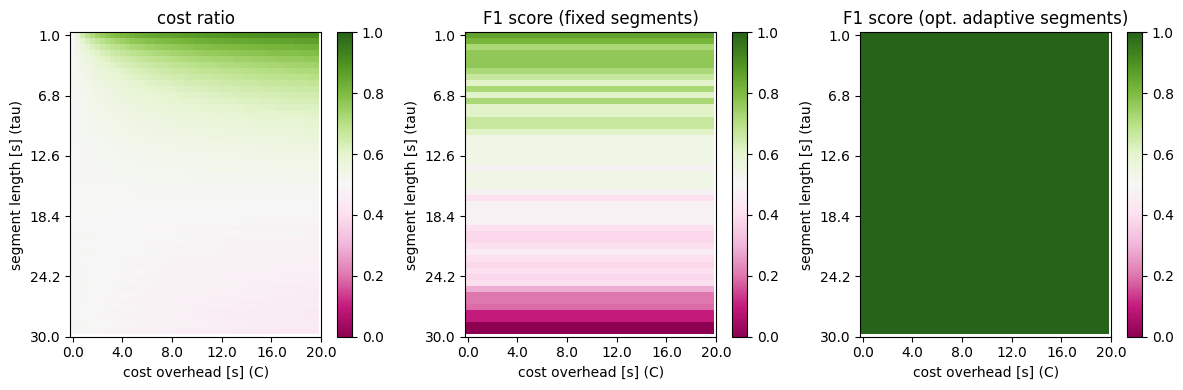

In [49]:
cost_ratio_result = cost_fixed / (cost_fixed + cost_oracle)
label_quality_ratio_result = label_quality_fixed #1 / (1 + label_quality_fixed)
print(label_quality_ratio_result.shape)
print(cost_ratio_result.shape)


cmap = matplotlib.colormaps['PiYG']

fig, ax = plt.subplots(1,3, figsize=(12,4))

img0 = ax[0].imshow(cost_ratio_result, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[0].set_title('cost ratio')
plt.colorbar(img0, ax=ax[0])

img1 = ax[1].imshow(label_quality_ratio_result, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[1].set_title('F1 score (fixed segments)')
plt.colorbar(img1, ax=ax[1])


img2 = ax[2].imshow(label_quality_oracle, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[2].set_title('F1 score (opt. adaptive segments)')
plt.colorbar(img2, ax=ax[2])

for idx in [0, 1, 2]:
    # set xticks
    xticks = ax[idx].get_xticks()[1:]
    #print(xticks)
    xticklabels = np.linspace(min_cost_overhead, max_cost_overhead, len(xticks))
    xticklabels = ['{:.1f}'.format(c) for c in xticklabels]
    #print(xticklabels)
    ax[idx].set_xticks(xticks)
    ax[idx].set_xticklabels(xticklabels)
    ax[idx].set_xlabel('cost overhead [s] (C)')
    
    # set yticks
    yticks = ax[idx].get_yticks()[1:]
    #print("y: ", yticks)
    yticklabels = np.linspace(min_segment_length, max_segment_length, len(yticks))
    yticklabels = ['{:.1f}'.format(c) for c in yticklabels]
    #print("yticklabels: ", yticklabels)
    ax[idx].set_yticks(yticks)
    ax[idx].set_yticklabels(yticklabels)
    ax[idx].set_ylabel('segment length [s] (tau)')

plt.tight_layout()
print(np.min(cost_ratio_result))

(2, 2)


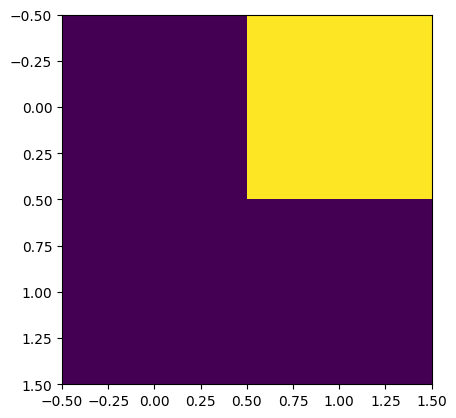

In [33]:
x = np.array([
    [0, 1],
    [0, 0]
])
print(x.shape)
plt.imshow(x)

In [8]:
# measure of label quality

# Baseline: fixed segment lengths
# simulate weak-labelling approach with fixed length segments
# 1. true label
# 2. sliding window with max

# compute cost of fixed length segment approach
# Oracle: optimal adaptive segment lengths
# compute cost of optimal adaptive segments approach

# Human: simulate sub-optimal adaptive segments approach, taking human characteristics into account
# 1. set minimum and maximum segment lengths
# 2. come up with reasonable heuristic
#     a. for all events shorter than min, place window on top of them
#     b. for all events longer than max, distribute window inside
#     c. for all remaining events, place optimal window on them
#     d. derive labels

# simulate annotator quality, if window overlaps too little with event, add label noise

# Figure 1. Label quality on y-axis, annotator cost on x-axis
# Baseline: plot this for different segment lengths, varying between minimum event length to maximum event length
# Oracle: plot this optimal point in figure. This is the least amount of annotation necessary (under the assumed cost model) to derive optimal labels.
# Human: plot this sub-optimal point in figure. This is approximately the least amount of annotation necessary to derive the sub-optimal labels.
#
# The idea of figure 1 is to convince the reader that the persuit of adaptive segmentation lengths can have benefits, 
# and to understand better under which scenarios it will have benefits. I think this is important.

# Things to vary.
#
# Annotator model. Different assumptions on label noise for sub-optimal overlap with event of interest.
# Cost model. Different assumptions on the constant overhead cost and the gradient for the linear cost.